#  ATOC5860 Application Lab #5 - check_python_convolution
##### Written by Prof. Kay (CU) and Prof. Maroon (formerly CU, now U-Wisconsin)
##### last updated March 12 - works with environment atoc5860env2024


### LEARNING GOAL:
1) Understand what is happening “under the hood” in different python functions that are used to smooth data in the time domain.

### DATA and UNDERLYING SCIENCE MOTIVATION:  

Data are monthly Nino3.4 sea surface temperature (SST) time series (a proxy for ENSO) from the
CESM1 Large Ensemble (doi: 10.1175/BAMS-D-13-00255.1, http://www.cesm.ucar.edu/projects/community-projects/LENS/). 
You will analyze pre-industrial control runs that represent perpetual 1850 conditions  (i.e., they have constant 1850 climate). Data are munged (preprocessed) by the NCAR CVDP package (doi: 10.1002/2014EO490002, http://www2.cesm.ucar.edu/working_groups/CVC/cvdp//data-repository.html). Note: these are the same data from Homework 4 :) Remember??? 

Use this notebook to understand the different python functions that can be used to smooth data in the time domain.  Compare with a “by hand” convolution function.  Look at your data by printing its shape and also values.  Understand what the python function is doing, especially how it is treating edge effects.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as sig
from matplotlib.gridspec import GridSpec
import timeit
import scipy.io as sio
import xarray
import pickle

In [2]:
## Read in the data.
fname1="CESM1_LENS_Coupled_Control.cvdp_data.401-2200.nc"
ds1=xarray.open_dataset(fname1,decode_times=False,decode_cf=False)
#ds1
data_fc=ds1["nino34"]
#print(data_fc)
nyrs=700
x=data_fc[0:12*nyrs]
    
## remove the mean (i.e., calculate the anomaly)
xa = x - np.mean(x)    

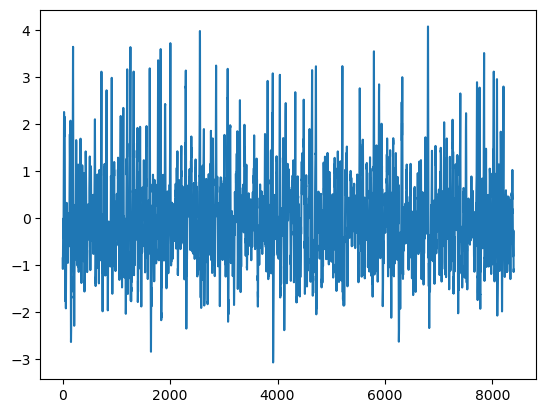

In [5]:
plt.plot(list(range(len(xa))), xa)

**What is under the hood with the python functions?**

**How are the edge effects treated?**


In [3]:
## Let's see what is going on.  We'll do the convolution manually as a reference.  Coding "from scratch" useful...
b=np.array([1,1,1])/3 ### a simple filter

print("Shape of Original Data")
print(np.shape(xa))

print("Original Data - first three points")
print(np.round(xa[0:3].values,2))
print("Convolution by hand - first three points")
by_hand_first3=xa[0].values*1/3,(xa[0].values*1+xa[1].values*1)/3,(xa[0].values*1+xa[1].values*1+xa[2].values*1)/3
print(np.round(by_hand_first3,2))
print("Convolution by hand - last three points")
by_hand_last3=(xa[-3].values*1+xa[-2].values*1+xa[-1].values*1)/3,(xa[-1].values*1+xa[-2].values*1)/3,xa[-1].values*1/3
print(np.round(by_hand_last3,2))

Shape of Original Data
(8400,)
Original Data - first three points
[-0.86 -1.03 -1.08]
Convolution by hand - first three points
[-0.29 -0.63 -0.99]
Convolution by hand - last three points
[-1.06 -0.75 -0.37]


**what does np.convolve do??**

lots of different things :). Read on...

In [4]:
## mode = 'full' is the default
y2=np.convolve(xa,b)
print("Convolution by np.convolve - first three points")
print(np.round(y2[0:3],2))
print("Convolution by np.convolve - last three points")
print(np.round(y2[-3:],2))
print("shape of array resulting from np.convolve")
print(np.shape(y2))

## 'full' starts with the first value and add points at the end - matches calculation by hand at both start and end
## This returns the convolution at each point of overlap, with an output shape of (N+M-1,). 
## At the end-points of the convolution, the signals do not overlap completely, and boundary effects may be seen.
y2=np.convolve(xa,b,'full')
print("Convolution by np.convolve 'full' - first three points")
print(np.round(y2[0:3],2))
print("Convolution by np.convolve 'full' - last three points")
print(np.round(y2[-3:],2))
print("shape of array resulting from np.convolve 'full'")
print(np.shape(y2))

## 'same' 
## Mode ‘same’ returns output of length max(M, N). Boundary effects are still visible.
y2=np.convolve(xa,b,'same')
print("Convolution by np.convolve 'same' - first three points")
print(np.round(y2[0:3],2))
print("Convolution by np.convolve 'same' - last three points")
print(np.round(y2[-3:],2))
print("shape of array resulting from np.convolve 'same'")
print(np.shape(y2))

## 'valid' 
## Mode ‘valid’ returns output of length max(M, N) - min(M, N) + 1. 
##The convolution product is only given for points where the signals overlap completely. 
##Values outside the signal boundary have no effect.
y2=np.convolve(xa,b,'valid')
print("Convolution by np.convolve 'valid' - first three points")
print(np.round(y2[0:3],2))
print("Convolution by np.convolve 'valid' - last three points")
print(np.round(y2[-3:],2))
print("shape of array resulting from np.convolve 'valid'")
print(np.shape(y2))

Convolution by np.convolve - first three points
[-0.29 -0.63 -0.99]
Convolution by np.convolve - last three points
[-1.06 -0.75 -0.37]
shape of array resulting from np.convolve
(8402,)
Convolution by np.convolve 'full' - first three points
[-0.29 -0.63 -0.99]
Convolution by np.convolve 'full' - last three points
[-1.06 -0.75 -0.37]
shape of array resulting from np.convolve 'full'
(8402,)
Convolution by np.convolve 'same' - first three points
[-0.63 -0.99 -1.02]
Convolution by np.convolve 'same' - last three points
[-0.88 -1.06 -0.75]
shape of array resulting from np.convolve 'same'
(8400,)
Convolution by np.convolve 'valid' - first three points
[-0.99 -1.02 -0.95]
Convolution by np.convolve 'valid' - last three points
[-0.6  -0.88 -1.06]
shape of array resulting from np.convolve 'valid'
(8398,)


**what does sig.lfilter do?** 
sig.lfilter uses np.convolve so it also starts with the first value, but cuts off the last value (at the end).

Source code here: https://github.com/scipy/scipy/blob/v1.5.4/scipy/signal/signaltools.py#L1719-L1909

In [5]:
yfilt=sig.lfilter(b,1,xa)
print("Filtering using lfilter - first three points")
print(np.round(yfilt[0:3],2))
print("Filtering using lfilter - last three points (it is ignoring last two points)")
print(np.round(yfilt[-3:],2))
print("shape of array resulting from sig.lfilter")
print(np.shape(yfilt))

Filtering using lfilter - first three points
[-0.29 -0.63 -0.99]
Filtering using lfilter - last three points (it is ignoring last two points)
[-0.6  -0.88 -1.06]
shape of array resulting from sig.lfilter
(8400,)


**what does sig.filtfilt do?**
1) apply the filter forward - cut it off second to last 
2) apply the filter backward - cut if off second to last (in other words the first point)

going each way -- you get to filter the edges from both directions at least once.
filtering using filtfilt makes the most of the data at the edges.
filtfilt makes the most of all of your data... so it's a good choice to use.
Look at the original python code - you can see filtfilt is applying lfilt twice
https://github.com/scipy/scipy/blob/v0.18.1/scipy/signal/signaltools.py#L858-L1041

**Notes on padding:**
When method is “pad”, the function pads the data along the given axis in one of three ways: odd, even or constant. 
The odd and even extensions have the corresponding symmetry about the end point of the data. 
The constant extension extends the data with the values at the end points. 
On both the forward and backward passes, the initial condition of the filter is found by using lfilter_zi and scaling it by the end point of the extended data.
When method is “gust”, Gustafsson’s method is used. Initial conditions are chosen for the forward and backward passes so that the forward-backward filter gives the same result as the backward-forward filter.





In [6]:
yfiltfilt=sig.filtfilt(b,1,xa)
print("Filtering using filtfilt")
print(np.round(yfiltfilt[0:3],2))
print("shape of array resulting from sig.lfilter")
print(np.shape(yfiltfilt))

Filtering using filtfilt
[-0.86 -0.95 -0.98]
shape of array resulting from sig.lfilter
(8400,)
